**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

# Data Preparation

In [7]:
class_name = 'Occupancy'
df = pd.read_csv('scaled_datatrainingcopy.csv', skipinitialspace=True, na_values='?', keep_default_na=True)


df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Week_day,Occupancy
0,2.518470,0.278526,1.573763,0.364948,1.091757,1,1
1,2.488967,0.277713,1.591735,0.341881,1.080555,1,1
2,2.488967,0.273645,1.573763,0.340290,1.075889,1,1
3,2.488967,0.265508,1.573763,0.323587,1.066555,1,1
4,2.439796,0.265508,1.573763,0.311655,1.049523,1,1


In [8]:
import sys
sys.path.append('./')

In [60]:
from data_preparation import prepare_dataset

In [62]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Week_day,Occupancy
0,2.518470,0.278526,1.573763,0.364948,1.091757,1,1
1,2.488967,0.277713,1.591735,0.341881,1.080555,1,1
2,2.488967,0.273645,1.573763,0.340290,1.075889,1,1
3,2.488967,0.265508,1.573763,0.323587,1.066555,1,1
4,2.439796,0.265508,1.573763,0.311655,1.049523,1,1


In [63]:
df[class_name].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

In [64]:
rows2remove = np.random.choice(df[df[class_name] == 1].index, 1729 - 50, replace=False)

In [65]:
len(df), len(rows2remove)

(8143, 1679)

In [66]:
df2 = df.drop(index=rows2remove, axis=0)
print(len(df2))
#numero di records eliminato occupancy = 1

6464


In [67]:
print('Dataset shape %s' % Counter(df2[class_name]))

Dataset shape Counter({0: 6414, 1: 50})


# Data Partitioning

In [68]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [69]:
attributes = [col for col in df.columns if col != class_name]
X = df2[attributes].values
y = df2[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [70]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)
#creto da nuovo numero di records train e test

((array([0, 1]), array([4489,   35])), (array([0, 1]), array([1925,   15])))

# Classification

In [71]:
from sklearn.tree import DecisionTreeClassifier

In [72]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.9958762886597938
F1-score [0.99792531 0.66666667]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1925
           1       0.89      0.53      0.67        15

    accuracy                           1.00      1940
   macro avg       0.94      0.77      0.83      1940
weighted avg       1.00      1.00      1.00      1940



# ROC curve

In [73]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [74]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

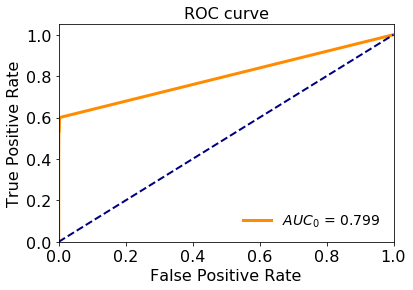

In [75]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Adjust the Decision Threshold

Accuracy 0.9953608247422681
F1-score [0.99766779 0.57142857]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1925
           1       1.00      0.40      0.57        15

    accuracy                           1.00      1940
   macro avg       1.00      0.70      0.78      1940
weighted avg       1.00      1.00      0.99      1940



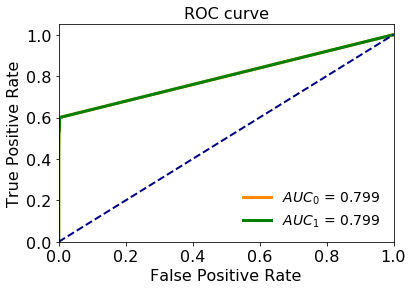

In [76]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

def adjusted_predict(X, thr=0.5):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

y_pred = adjusted_predict(X_test, thr=0.8)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# PCA

In [77]:
from sklearn.decomposition import PCA

In [78]:
X_train.shape #del primo array 0+1

(4524, 6)

In [79]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

In [80]:
X_pca.shape #2 is the number of components, dimensionality reduction

(4524, 2)

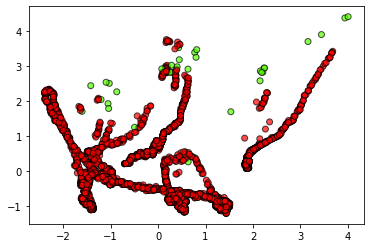

In [82]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

# Undersampling

In [83]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

### RandomUnderSampler

In [84]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 35, 1: 35})


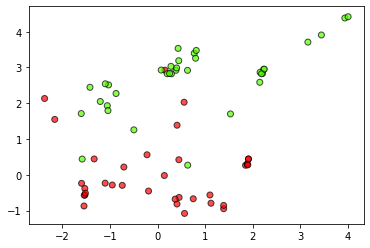

In [85]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9695876288659794
F1-score [0.98443682 0.33707865]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1925
           1       0.20      1.00      0.34        15

    accuracy                           0.97      1940
   macro avg       0.60      0.98      0.66      1940
weighted avg       0.99      0.97      0.98      1940



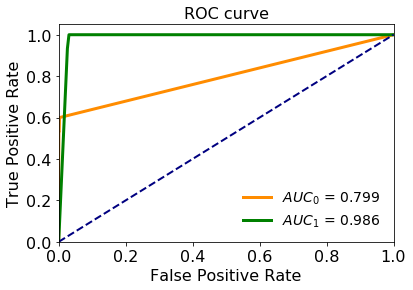

In [86]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### CondensedNearestNeighbour

In [87]:
import warnings
warnings.simplefilter("ignore")

In [88]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 35, 0: 22})


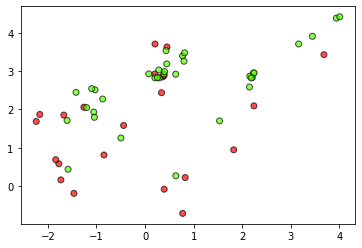

In [89]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9927835051546392
F1-score [0.99636364 0.53333333]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1925
           1       0.53      0.53      0.53        15

    accuracy                           0.99      1940
   macro avg       0.76      0.76      0.76      1940
weighted avg       0.99      0.99      0.99      1940



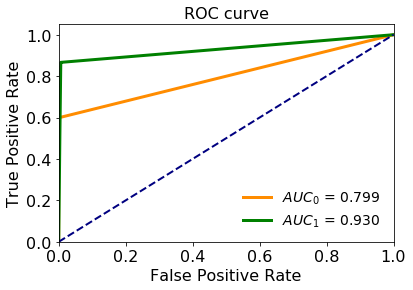

In [90]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Oversampling

In [91]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### RandomOverSampler

In [92]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4489, 1: 4489})


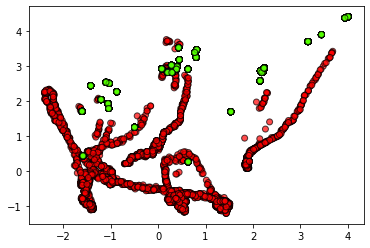

In [93]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9974226804123711
F1-score [0.99870164 0.82758621]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1925
           1       0.86      0.80      0.83        15

    accuracy                           1.00      1940
   macro avg       0.93      0.90      0.91      1940
weighted avg       1.00      1.00      1.00      1940



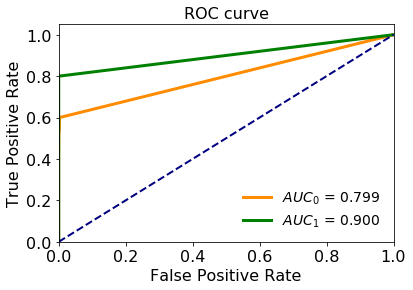

In [94]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### SMOTE

In [95]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4489, 1: 4489})


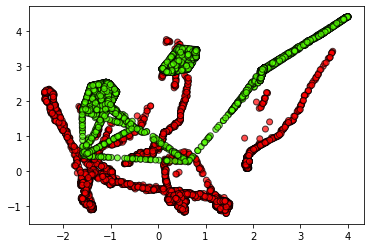

In [96]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9958762886597938
F1-score [0.99791883 0.77777778]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1925
           1       0.67      0.93      0.78        15

    accuracy                           1.00      1940
   macro avg       0.83      0.96      0.89      1940
weighted avg       1.00      1.00      1.00      1940



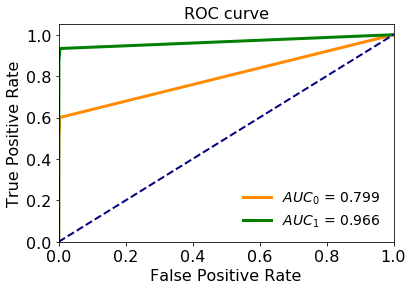

In [97]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Class Weight 

Accuracy 0.9969072164948454
F1-score [0.99844156 0.8       ]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1925
           1       0.80      0.80      0.80        15

    accuracy                           1.00      1940
   macro avg       0.90      0.90      0.90      1940
weighted avg       1.00      1.00      1.00      1940



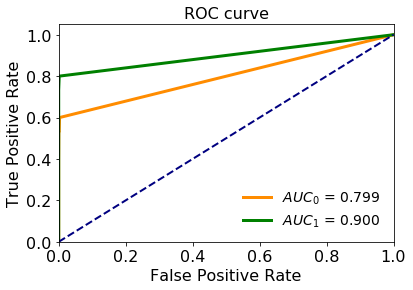

In [98]:
clf = DecisionTreeClassifier(min_samples_leaf=3, class_weight={0:1, 1: 5}, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Meta-Cost Sensitive Classifier

In [100]:
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.metrics import savings_score

ImportError: cannot import name 'six' from 'sklearn.externals' (/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/__init__.py)

cost_mat : array-like of shape = [n_samples, 4]

Cost matrix of the classification problem Where the columns represents the costs of: false positives, false negatives, true positives and true negatives, for each example.

In [55]:
cost = [1, 10, 0, 0]
cost_mat = np.array([cost] * len(X_train))
cost_mat.shape

(2333, 4)

In [56]:
cost_mat

array([[ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       ...,
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0]])

Accuracy 0.426
F1-score [0.51273345 0.30170316]
              precision    recall  f1-score   support

           0       0.93      0.35      0.51       855
           1       0.18      0.86      0.30       145

    accuracy                           0.43      1000
   macro avg       0.56      0.60      0.41      1000
weighted avg       0.83      0.43      0.48      1000



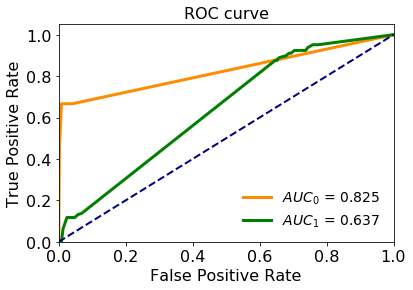

In [57]:
clf = CostSensitiveDecisionTreeClassifier()
clf.fit(X_train, y_train, cost_mat)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [58]:
cost_mat_test = np.array([cost] * len(X_test))
print(savings_score(y_test, y_pred, cost_mat_test))
print(savings_score(y_test, y_pred0, cost_mat_test))

0.10760233918128659


ValueError: operands could not be broadcast together with shapes (870,) (1000,) 

# Scikit-plot

In [46]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [47]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.932
F1-score [0.96046512 0.75714286]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       855
           1       0.79      0.73      0.76       145

    accuracy                           0.93      1000
   macro avg       0.87      0.85      0.86      1000
weighted avg       0.93      0.93      0.93      1000



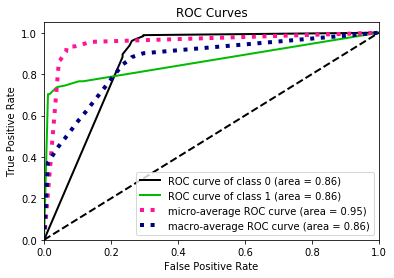

In [48]:
plot_roc(y_test, y_score)
plt.show()

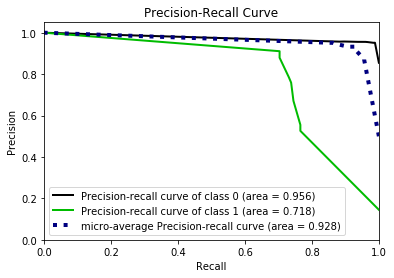

In [49]:
plot_precision_recall(y_test, y_score)
plt.show()

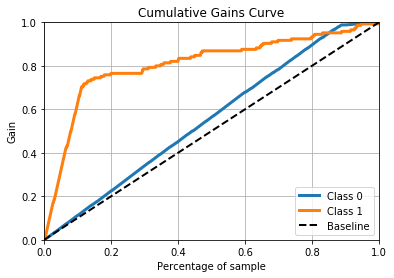

In [50]:
plot_cumulative_gain(y_test, y_score)
plt.show()

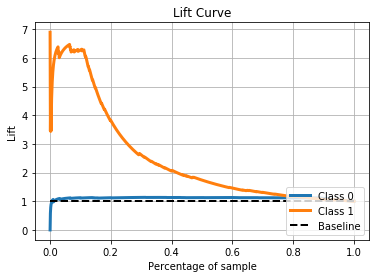

In [51]:
plot_lift_curve(y_test, y_score)
plt.show()